# Connectionist Sudoku
This is my attempt to use Paul Thagard's ECHO algorithm for solving Sudoku.
ECHO is a connectionist algorithm for finding the most coherent explanations for observations and our idea was to adopt this for the constraint satisfaction game. 

Source: https://www.cambridge.org/core/journals/behavioral-and-brain-sciences/article/explanatory-coherence/E05CB61CD64C26138E794BC601CC9D7A


#### ToDo:
- try probabilistic activation propagation to smooth out solving/escape local minima
- what's the energy function here?
- implement accuracy to better compare performance with different inhibitions, activation initializations, etc.
- implement the Hopfield network analogue


### Nomenclature for Sudoku
Copied from Peter Norvig:
http://norvig.com/sudoku.html

Shown with a simple 4x4 Sudoku:

![alt-text](https://raw.githubusercontent.com/MaxRae/ConnectionistSudoku/master/Media/SudokuNomenclature.png)

### Sketch of the weight matrix
Example of a 4x4 Sudoku
![alt text](https://raw.githubusercontent.com/MaxRae/ConnectionistSudoku/master/Media/WeightMatrix.png)


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Setting up the units
One unit represents one proposition, for example "There is a 1 in the first square." The activation of a unit represents its plausibility.


The activation of units that are given (i.e. numbers that are already filled at the beginning) is clamped at 1.

In [0]:
class Unit:
    def __init__(self, activation, index):
        self.activation = activation
        self.index = index
        self.activation_history = [self.activation]
        
    def update(self, weights, activations,  threshold, decay=.1):
        """Simply the updating rule by Thagard (1989)"""
        i,j,k = self.index
        previous_activation = self.activation
        net = sum(sum(sum(weights[i,j,k] * activations)))
        if net > 0:
            self.activation = self.activation*(1-decay) + net*(1-self.activation)
        else: 
            self.activation = self.activation*(1-decay) + net*(self.activation + 1)
        self.activation = np.round(self.activation, decimals=2)
        self.activation_history.append(self.activation)
        
        difference = np.abs(previous_activation-self.activation)
        if difference > threshold:
            return True
        

            
class ClampedUnit(Unit):
    # So called evidence units whose activation is fixed
    # In our case the sudoku numbers filled from the start
    def update(self, *args, **kwargs):
        self.activation_history.append(self.activation)
            
          

## Setting up ECHO
We need to specify the weights between all units, initiliaze all units and clamped units and then be able to update their activation according to the weights between the units.

In [0]:
def get_boxindeces(size):
    """Reused code for getting i,j indexes of the squares in the boxes in a 
    Sudoku. Writing this caused some brain strain."""
    boxindeces = []
    blocklength = int(np.sqrt(size))
    for m in range(0, size, blocklength):
        for n in range(0, size, blocklength):
            box = []
            for k in range(0, blocklength):
                box.append((m+k,n))
                for l in range(1, blocklength):
                    box.append((m+k, n+l))
            boxindeces.append(box)
    return boxindeces

In [0]:
class ECHO:
    def __init__(self, sudoku, threshold=.1):
        self.threshold = threshold
        # Sudoku is passed like this:
        # example4x4 = [[0., 1., 0., 0.], [0., 0., 0., 1.], ...]
        # = 2 in first and a 4 in second square
        self.size = len(sudoku[0]) # this should be 4, for the example
        
        # create a list of units, where one unit corresponds to a proposition
        # e.g. unit 1 = "There is a 1 at position [1,1]"
        self.units = []
        # m corresponds to the number of the square counted from top left 
        # to right row-wise
        # If the square already has a number, this unit's activation is clamped at 1
        for m, square in enumerate(sudoku):
            i, j = m//self.size, m%self.size
            for k, number in enumerate(square):
                activation = np.random.rand(1)[0]*2-1
                if not number and not any(square):
                    self.units.append(Unit(activation, index=(i,j,k)))
                elif number == 1:
                    self.units.append(ClampedUnit(activation = 1, index=(i,j,k)))
                elif not number and any(square):
                    self.units.append(ClampedUnit(activation = -1, index=(i,j,k)))
                else:
                    raise ValueError('An...unacceptable...condition!')
        
        self.weight_init()
        
    def weight_init(self):
        """Initialize the weight matrix
        For example, having a 4 in one square should inhibit all 4 units in
        the same column, row and box."""
        # for format of the weights, see above picture 
        # weights[i,j,k] gives you a 3D matrix of the weights between the unit at
        # i,j,k and all other units
        size = self.size
        self.weights = np.zeros([size]*6)
        cohypotheses = 4*(size-1) # amount of non-zero weights every unit has        
        # getting the indeces for the squares in the n boxes of the sudoku
        boxindeces = get_boxindeces(size)
        
        zero2size = list(range(size))
        # iterating through the 3D Sudoku, see picture above
        positions = itertools.product(zero2size, zero2size, zero2size)
        for i,j,k in positions:
            # First: inhibition within one square
            for number in zero2size:
                self.weights[i,j,k,i,j,number] = -1/cohypotheses

            # Second: inhibition withing a box
            # index tells us in which box our current square lies
            index = [x for x,y in enumerate(boxindeces) if (i,j) in y][0]
            currentbox = boxindeces[index]
            for (square_i, square_j) in currentbox:
                self.weights[i,j,k,square_i,square_j,k] = -1/cohypotheses

            # Third: inhibitions in rows and columns
            for l in zero2size:
                self.weights[i,j,k,l,j,k] = -1/cohypotheses #first the column
                self.weights[i,j,k,i,l,k] = -1/cohypotheses #then the row
                
            # Fourth: remove self-inhibition
            self.weights[i,j,k,i,j,k] = 0
                                
        
    def weight_update():
        """Wait, I don't update the weights, only the activations"""
        pass
    
    def return_activations(self):
        """Returns the activations of all units in a 3D matrix"""
        zero2size = list(range(self.size))
        activations = np.zeros([self.size]*3)
        
        # iterating through the 3D Sudoku, see picture above
        positions = itertools.product(zero2size, zero2size, zero2size)
        for n,ijk in enumerate(positions):
            i,j,k = ijk
            activations[i][j][k] = self.units[n].activation
        return activations
        
    def activation_update(self):
        """Updating the activations of all units in one step"""
        activations = self.return_activations()
        threshold_crossed = False
        for unit in self.units:
            crossed = unit.update(self.weights, activations, 
                                  threshold=self.threshold, decay = .1)
            if crossed: 
                threshold_crossed = True
        if not threshold_crossed:
            print("Convergence reached.", end=" ")
            return True
        else:
            return False
                
    def plot_activation_history(self):
        zero2size = list(range(self.size))
        positions = itertools.product(zero2size, zero2size)
        print(self.size)
        fig = plt.figure(figsize=(2*self.size,2*self.size))
        fig.suptitle("History of activations for the numbers in all squares of the sudoku")
        ncols = nrows = self.size
        #if self.size==4: colors = ['#E9B000', '#E24E42', '#008F95', 'black']
        for i, index in enumerate(positions):
            max_act = (0,0)
            for number in range(self.size):
                history = self.units[i*self.size+number].activation_history
                plt.subplot(nrows, ncols, i+1)
                plt.plot(range(len(history)), history)#, c=colors[number])
                plt.ylim((-1.1,1.1))
                plt.yticks([])
                plt.text(len(history), history[-1], "{}".format(number+1), 
                        bbox=dict(facecolor="white"))
                if history[1] == 1:
                    plt.text(30,0, "{}".format(number+1), fontsize=40, 
                             bbox=dict(facecolor="white"))
                # the number with the highest activation should be visible on top
                if history[-1] > max_act[1]:
                    max_act = (number, history[-1])
            
            plt.text(len(history), max_act[1], "{}".format(max_act[0]+1), 
                    bbox=dict(facecolor="#FFF7C4"))    

    

## Running a few example Sudokus

In [0]:
def to_binary(sudoku):
    new = np.zeros((len(sudoku), int(np.sqrt(len(sudoku)))))
    for i, entry in enumerate(sudoku):
        if entry == 0: continue
        new[i, int(entry-1)] = 1
    return new

sudo = [1,2,3,4,
        0,0,0,0,
        0,0,0,0,
        0,1,2,0]
example4x4 = to_binary(sudo)

sudo = [5,3,0,0,7,0,0,0,0,
       6,0,0,1,9,5,0,0,0,
       0,9,8,0,0,0,0,6,0,
       8,0,0,0,6,0,0,0,3,
       4,0,0,8,0,3,0,0,1,
       7,0,0,0,2,0,0,0,6,
       0,6,0,0,0,0,2,8,0,
       0,0,0,4,1,9,0,0,5,
       0,0,0,0,8,0,0,7,9]
example9x9 = to_binary(sudo)

sudo = [5,3,4,6,7,8,9,1,2,
              6,7,2,1,9,5,3,4,8,
              1,9,8,3,4,2,5,6,7,
              8,5,9,7,6,1,4,2,3,
              4,2,6,8,5,3,7,9,1,
              7,1,3,9,2,4,8,5,6,
              9,6,1,5,3,7,2,8,4,
              2,8,7,4,1,9,6,3,5,
              3,4,5,2,8,6,1,7,9]
example9x9_solved = to_binary(sudo)

### 4x4 Sudoku

Convergence reached. 4


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


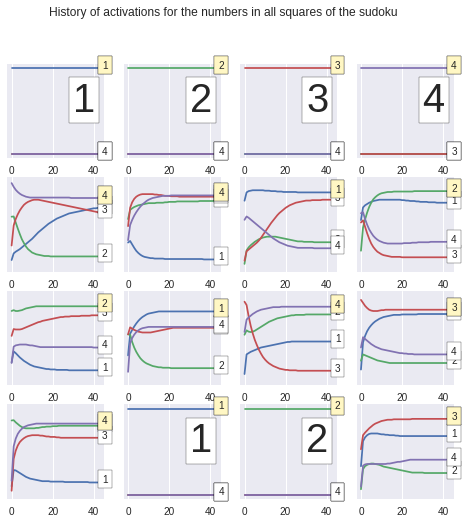

In [27]:
sudoku1 = ECHO(example4x4, threshold=.01)
finished = False
while not finished:
    finished = sudoku1.activation_update()

sudoku1.plot_activation_history()

### 9x9 Sudoku

Convergence reached. 9


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


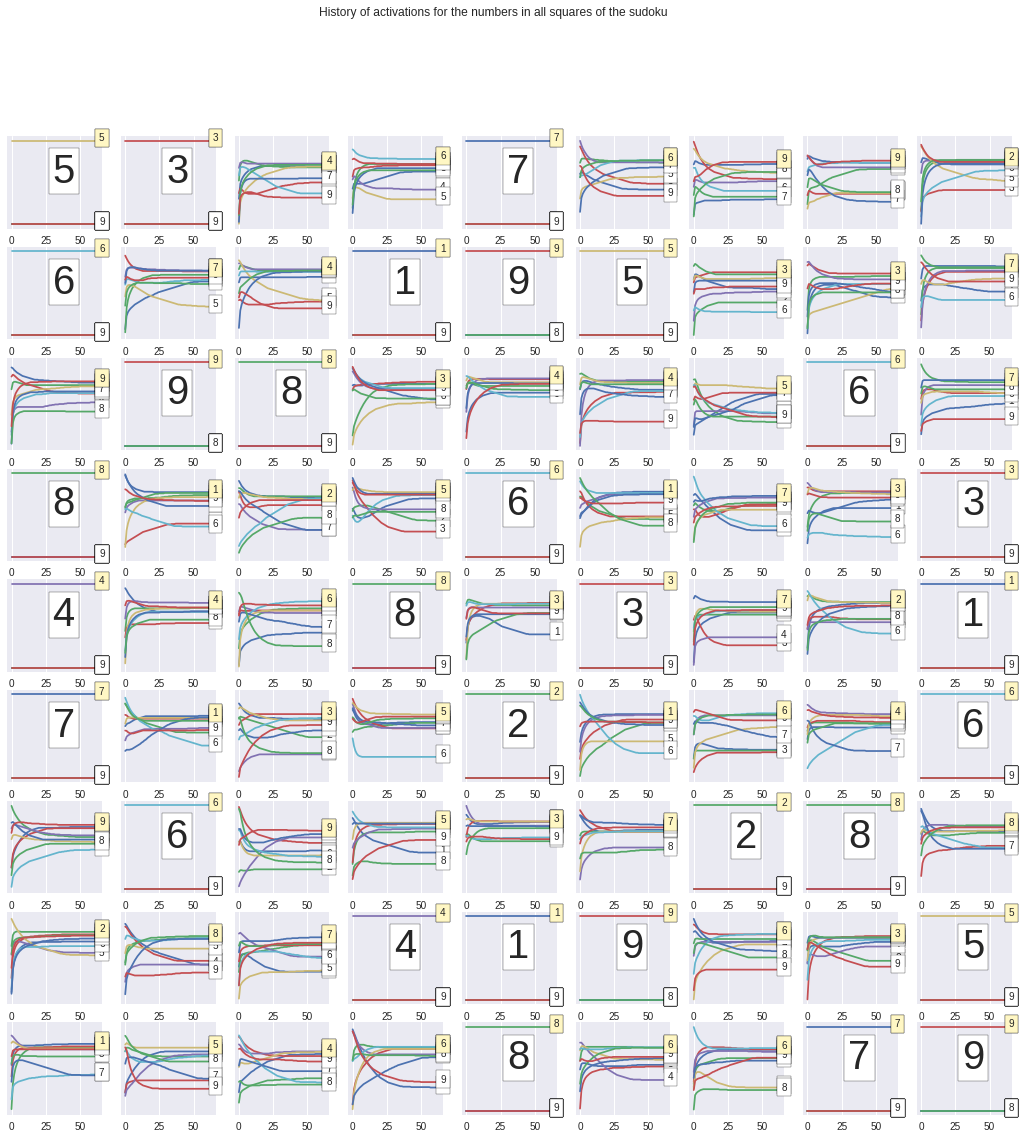

In [28]:
sudoku2 = ECHO(example9x9, threshold=.01)
finished = False
while not finished:
    finished = sudoku2.activation_update()

sudoku2.plot_activation_history()

### Observations:
- after initializing the activations randomly I see a lot of fluctuation in the final activation
- in almost all cases at least one incorrect number also ends up with high activation
- the correct number has a high activation more often than not

### Further ideas:
- ensemble ECHO, i.e. aggregate the activations of multiple runs with different initial activations


### Does the weight matrix look right?

In [9]:
# The initialized weight matrix seems to be correct
# Take a look the weights for the unit "There is a 2 in the second 
# square of the second row".
# The first of the four matrices = the weights between the unit and the 
# first row (i=0). 
# First vector in the first matrix = weights with all numbers withing one square.
sudoku1.weights[1,1,1]

array([[[ 0.        , -0.08333333,  0.        ,  0.        ],
        [ 0.        , -0.08333333,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        , -0.08333333,  0.        ,  0.        ],
        [-0.08333333,  0.        , -0.08333333, -0.08333333],
        [ 0.        , -0.08333333,  0.        ,  0.        ],
        [ 0.        , -0.08333333,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.08333333,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.08333333,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]])

Answer: **Yes**

## Ensemble ECHO

In [0]:
def ensemble(sudoku, n=10):
    final_activations = []
    for i in range(n):
        sudoku_task = ECHO(sudoku, threshold=.01)
        finished = False
        while not finished:
            finished = sudoku_task.activation_update()
        final_activations.append(sudoku_task.return_activations())
    return(sum(final_activations)/n)

def plot_final_activation(final_activation, n):
    size = len(final_activation[0])
    zero2size = list(range(size))
    positions = itertools.product(zero2size, zero2size)

    fig = plt.figure(figsize=(2*size,2*size))
    fig.suptitle("Final average activations after n = {} runs".format(n))
    ncols = nrows = len(final_activation[0])
    for n, ij in enumerate(positions):
        i,j = ij
        plt.subplot(nrows, ncols, n+1)
        max_act = (0, 0) # (number, activation)
        for k in range(size):
            history = final_activation[i,j,k]
            plt.scatter(10, history)
            plt.text(10+k/2+1, history, "{}".format(k+1), bbox=dict(facecolor="white"))
            if history == 1:
                plt.text(5,-.5, "{}".format(k+1), fontsize=60, bbox=dict(facecolor="white"))
            if history > max_act[1]:
                max_act = (k, history)
        plt.ylim((-1.1,1.1))
        plt.xlim((0,20))
        plt.xticks([])
        plt.text(10+max_act[0]/2+1, max_act[1], "{}".format(max_act[0]+1), 
            bbox=dict(facecolor="#FFF7C4"))    



### 4x4 Sudoku 

Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. 

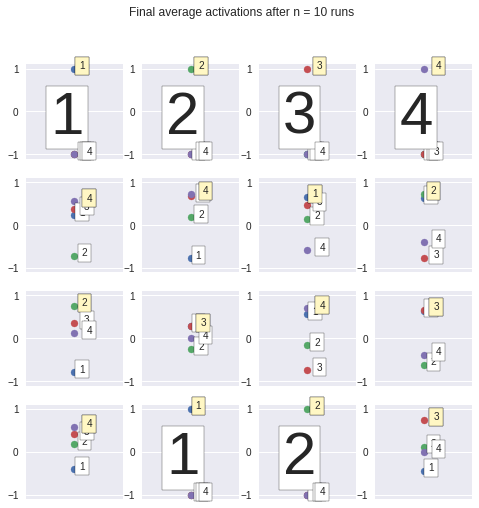

In [44]:
n = 10
final_activation = ensemble(example4x4, n=n)
plot_final_activation(final_activation, n)

### 9x9 Sudoku

Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. 

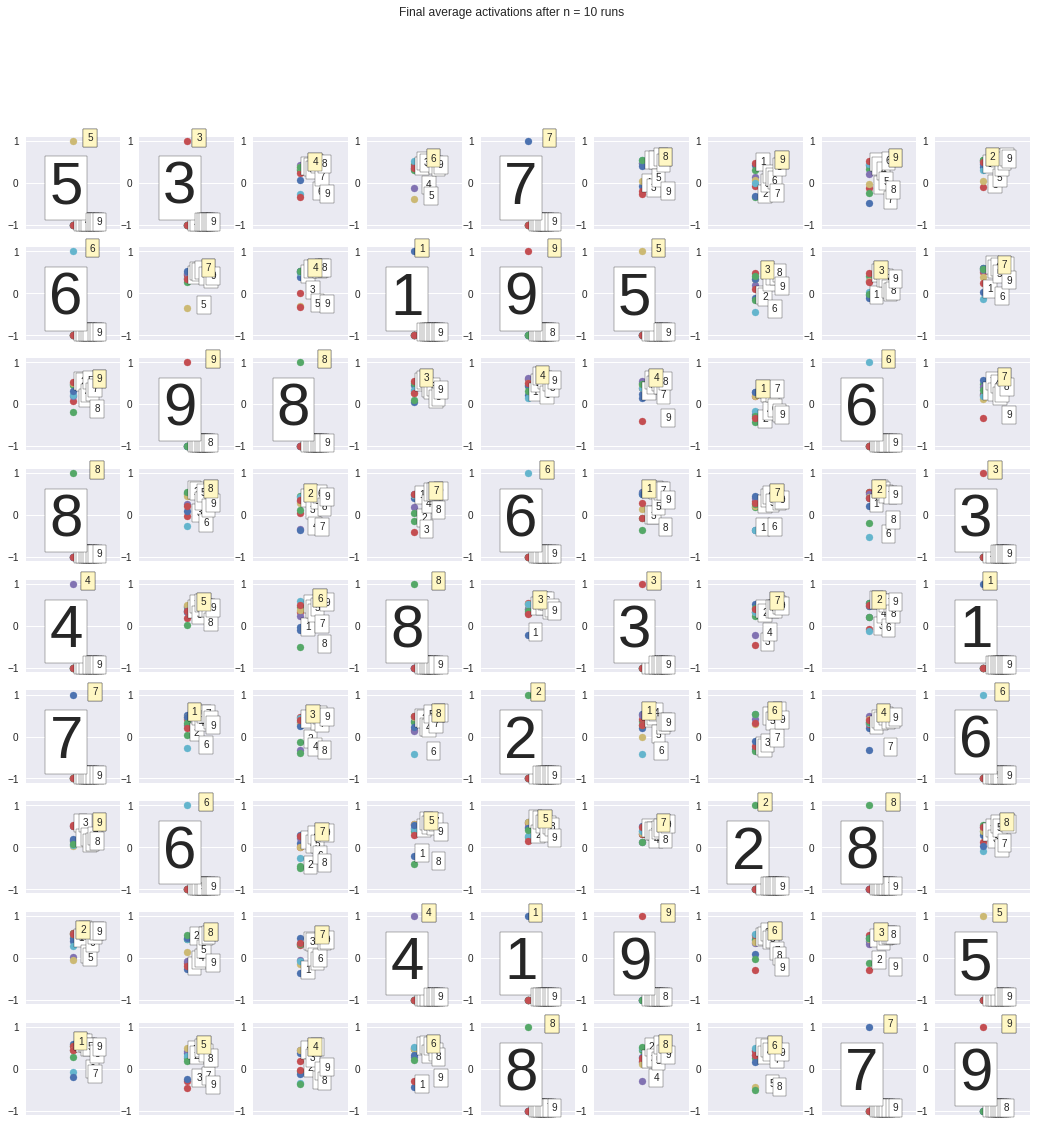

In [45]:
n = 10
final_activation = ensemble(example9x9, n=n)
plot_final_activation(final_activation, n)

### Observations
- the ensemble of 10 runs always gave the correct number the highest activation *for easy sudokus*
- does this work with more difficult 4x4 Sudokus?
 - less well, in more difficult ones ECHO regularly gives the wrong number the highest activation (maybe 80% accuracy?)
 - correct answer then mostly comes in second
- how about 9x9 Sudokus?
 - same picture as 4x4, works with very easy Sudokus, performance decreases for more difficult ones
 - correct number seems to be highest or second highest activation
 
**Some tinkering**
- Does stronger inhibition between numbers within one square cause ECHO to be more decisive for each square?
 - did not observe much change after a bit of testing (ca. 4 times stronger inhibition within square)
- Does greater variance in the initialization of activations help?
 - yes, seems so, something along the lines of better escaping local minima?
 - This might have been random though, better check again with actual accuracy scores
 
**Further ideas**
- something something probabilistic instead of total activation updating to smooth out convergence?
- play around with the idea of an energy function, is the local minimum of the energy the correctly filled Sudoku?
- what happens if I give all the right numbers a high activation in the beginning and the incorrect ones a low activation
 - will it converge to this activation distribution or leave it for a less correct one?
  - I suspect it will leave it. Some correct numbers are too "vulnerable"/too many inferences away from the clamped units to ensure the survival of their activation
 - implement the analogue Hopfiel-Network approach (step-activation function, stochastic activation updates, inhibition-weights = -2, thresholds = -1)

## What's the optimal convergence? 

I give the network a solved Sudoku and unclamp their weights, so we will see if this is a global optimum to which the network can converge to.

In [0]:
class ECHO_unclamped(ECHO):
    def __init__(self, sudoku, threshold=.1):
        self.threshold = threshold
        # Sudoku is passed like this:
        # example4x4 = [[0., 1., 0., 0.], [0., 0., 0., 1.], ...]
        # = 2 in first and a 4 in second square
        self.size = len(sudoku[0]) # this should be 4, for the example
        
        # create a list of units, where one unit corresponds to a proposition
        # e.g. unit 1 = "There is a 1 at position [1,1]"
        self.units = []
        # m corresponds to the number of the square counted from top left 
        # to right row-wise
        # If the square already has a number, this unit's activation is clamped at 1
        for m, square in enumerate(sudoku):
            i, j = m//self.size, m%self.size
            for k, number in enumerate(square):
                activation = np.random.rand(1)[0]*.5-1
                if not number and not any(square):
                    self.units.append(Unit(activation, index=(i,j,k)))
                # UPDATE: Units with numbers are not clamped! 
                elif number == 1:
                    self.units.append(Unit(-activation, index=(i,j,k)))
                elif not number and any(square):
                    self.units.append(Unit(activation = activation, index=(i,j,k)))
                else:
                    raise ValueError('An...unacceptable...condition!')
        
        self.weight_init()


Convergence reached. 9


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


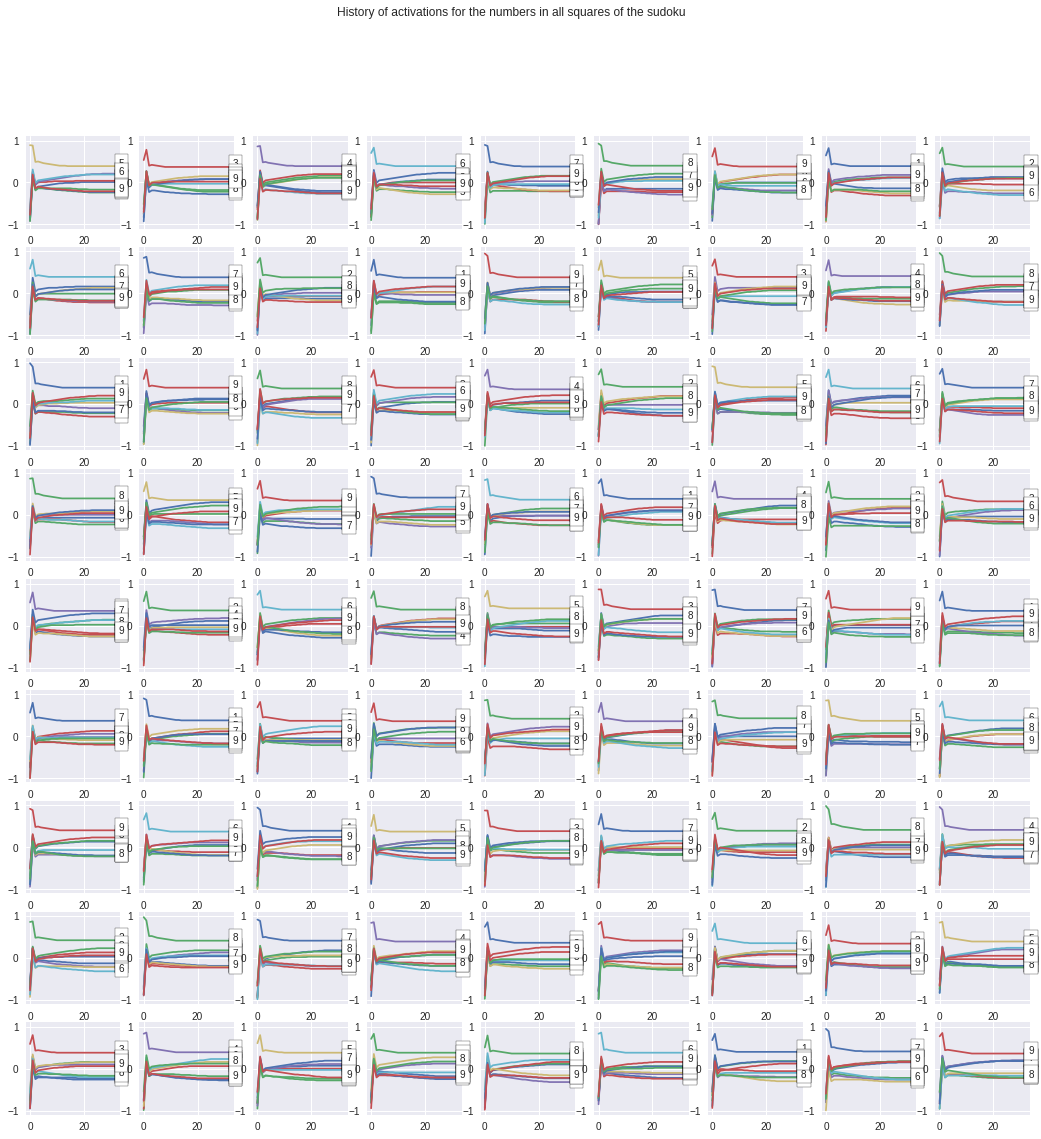

In [14]:
sudoku3 = ECHO_unclamped(example9x9_solved, threshold=.01)
finished = False
while not finished:
    finished = sudoku3.activation_update()

sudoku3.plot_activation_history()

### Observations:
- one equilibrium is for all activations being close to 0 with the correct number slighty above all the rest
- even having some randomness around the initial activations does not seem to change this pattern